Import NLP packages. Not all will be used for this project - it depends on how interesting the results are in most cases. For example, I used pattern.en, but found sentiment, mood, and modality analysis didn't offer much insight.

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer


# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

/Users/nickryan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
nltk.download('punkt')

True

In [5]:
# pull tweets out of MongoDB
from pymongo import MongoClient

client = MongoClient()
db = client.test

# pull tweets out of mongo
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [6]:
# trump data
dt_data = out_of_mongo(db.trumptweets3)

In [7]:
# check to see how many tweets
len(dt_data)

3199

In [8]:
# save with pickle
with open('pickled/tweetslong.pickle', 'wb') as handle:
    pickle.dump(dt_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('pickled/tweetslong.pickle', 'rb') as handle:
  b = pickle.load(handle)

In [10]:
# convert to pandas df
def data_to_df(data):
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count',  
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 'retweeted_status', 
            'entities', 'source']
    df = df[keep]
    return df

dt = data_to_df(dt_data)

In [11]:
dt.describe()

,id,favorite_count,retweet_count,quoted_status_id,in_reply_to_status_id
count,3.184000e+03,3184.000000,3184.000000,7.000000e+01,1.000000e+00
mean,7.193127e+17,14638.560616,5242.841080,7.195472e+17,7.667416e+17
std,2.653733e+16,13367.874565,5772.219928,2.355640e+16,NaN
min,6.784247e+17,0.000000,405.000000,6.784228e+17,7.667416e+17
25%,6.964426e+17,6446.250000,2282.000000,NaN,NaN
50%,7.142374e+17,11459.000000,3998.500000,NaN,NaN
75%,7.417473e+17,19164.000000,6565.750000,NaN,NaN
max,7.697406e+17,292514.000000,168586.000000,7.689335e+17,7.667416e+17


In [12]:
dt.shape

(3184, 13)

In [13]:
# metadata features

def is_retweet(retweeted_status):
    try:
        if np.isnan(retweeted_status) == True:
            return 
    except:
        return 1
    
def get_week(date):
    week = date - timedelta(days = date.weekday())
    return week

def add_metadata(df):
    df.loc[:, 'date'] = df.loc[:, 'created_at'].apply(lambda x: pd.to_datetime(x).date())
    df.loc[:, 'is_retweet'] = df.loc[:, 'retweeted_status'].apply(is_retweet)
    df.loc[:, 'week'] = df.loc[:, 'date'].apply(get_week)    
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [14]:
add_metadata(dt)

In [15]:
def plot_feats(df, featurelist):   
    plt.figure(figsize = (20, 8))
    plt.title('Retweets and Favorites', fontsize = 14)
    for feature in featurelist:
        plt.plot(df[feature])
    plt.legend(loc = 'best')
    plt.show()

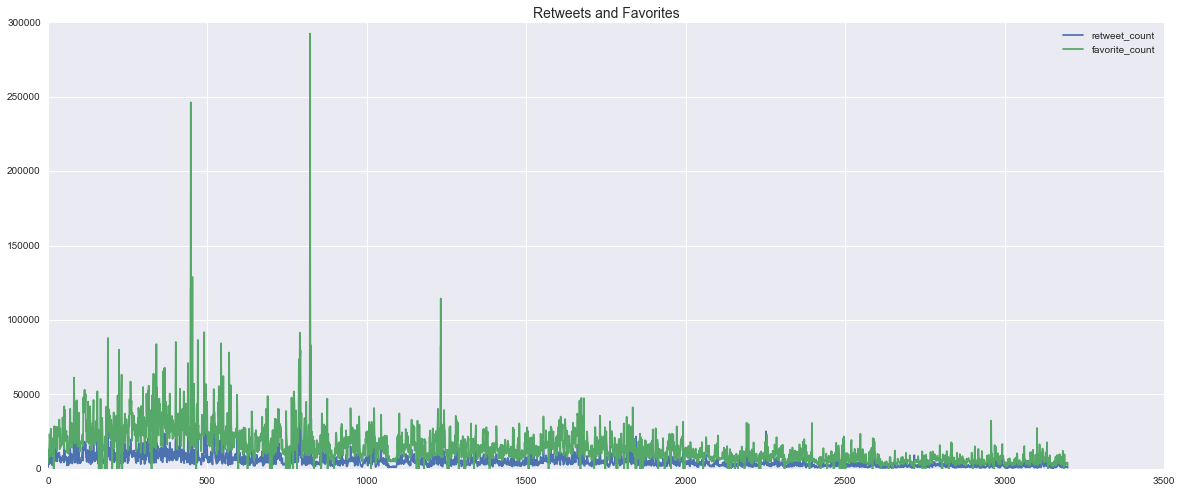

In [16]:
# compare retweets vs. favorites (tweets ordered new to old, left to right)

plot_feats(dt, ['retweet_count', 'favorite_count'])

That's a little dense, so let's aggregate by date.

In [17]:
# group by date

groupby_date_fav = dt['favorite_count'].groupby(dt['date'])
groupby_date_rt = dt['retweet_count'].groupby(dt['date'])

In [18]:
meanfav_df = groupby_date_fav.mean()
meanrt_df = groupby_date_rt.mean()
meanfav_df.head()
meanrt_df.head()

date
2015-12-20    1848.176471
2015-12-21    2331.142857
2015-12-22    1317.285714
2015-12-23    3167.263158
2015-12-24    2981.533333
Name: retweet_count, dtype: float64

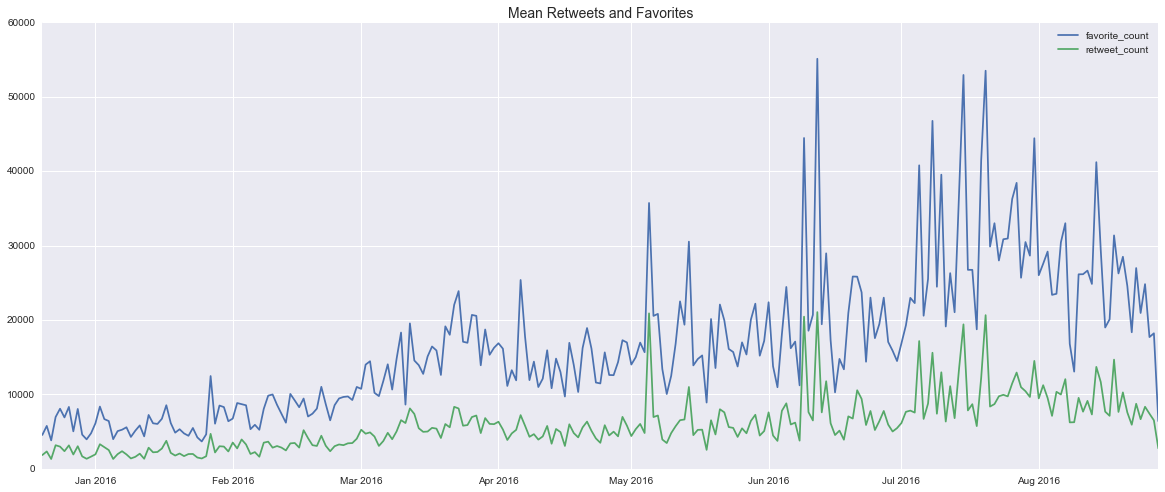

In [20]:
# favorites and retweets reduced variance (by date)

def plot_compare(dfs): 
    plt.figure(figsize = (20, 8))
    plt.title('Mean Retweets and Favorites', fontsize = 14)
    for df in dfs:
        plt.plot(df)
    plt.legend(loc = 'best')
    plt.show()
    
plot_compare([meanfav_df, meanrt_df])

In [21]:
# Tokenize tweets, with a number of options:
#
# word_tokenizer from nltk
# TweetTokenizer from nltk
# Custom tokenizer designed for twitter from https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [22]:
dt.loc[:, 'sentences'] = dt.loc[:, 'text'].apply(sent_tokenize)
dt.loc[:, 'tokens']    = dt.loc[:, 'text'].apply(preprocess)

In [23]:
# get tweets, remove links and @ mentions, and export for neural net training
tweettext = dt['text']
tweettext = tweettext.replace({r"(?:\@|https?\://)\S+": ""}, regex=True)
tweettext.to_csv('alltweets.csv', encoding='utf-8')

In [24]:
# what device are these tweets coming from?
dt['source'].value_counts()

<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    1608
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      1340
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       226
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>          7
<a href="http://instagram.com" rel="nofollow">Instagram</a>                                2
<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>                    1
Name: source, dtype: int64

In [25]:
# convert to keys
keys = {'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>': 'Android', 
        '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone', 
        '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Web'}
dt = dt.replace({"source": keys})

Now we'll import the emotion lexicon from http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm by Saif Mohammad, whose site is a superb resource on, among other things NLP and computational linguistics related, text analysis and analysis of emotional content. This lexicon includes multiple languages - which I've deleted for ease of handling already - and marks words according to whether or not they match in emotional content. The lexicon was done by hand (Mechanical Turk I think).

In [26]:
# import emotion lexicon
emotion_lexicon = pd.read_csv('NRC_Emotion_Lexicon.csv', header=0)
emotion_lexicon[1:20]

,English Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0
5,abate,0,0,0,0,0,0,0,0,0,0
6,abatement,0,0,0,0,0,0,0,0,0,0
7,abba,1,0,0,0,0,0,0,0,0,0
8,abbot,0,0,0,0,0,0,0,0,0,1
9,abbreviate,0,0,0,0,0,0,0,0,0,0
10,abbreviation,0,0,0,0,0,0,0,0,0,0


I don't want to go overboard in tailoring this lexicon to Donald Trump's speech patterns, but it is probably important that "crooked" be included since it appears so frequently in his tweets.

In [27]:
'crooked' in emotion_lexicon['English Word']

False

In [28]:
# add "crooked"
emotion_lexicon.loc[1]=['crooked', 0,1,0,0,1,0,0,0,0,0] 

In [29]:
# list of emotions
affects = ['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
           'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']

# create emotion dictionary
emotion_words = dict()
for key in affects:
    emotion_words[key] = emotion_lexicon[(emotion_lexicon[key] == 1)]['English Word'].tolist()

In [30]:
# counts number of words in tweet matching values in emotion dictionary for a given emotion
def emotioncount(df, emotion):
    col = []
    for line in df:
        emotcount = 0
        for word in line:
            if word in emotion_words[emotion]:
                emotcount = emotcount + 1
        col.append(emotcount)
    return col

In [31]:
# how many tokens (words) in each tweet? create a column specifying this
dt.loc[:, 'number of tokens'] = dt['tokens'].apply(len)

# for each emotion, create a column with the number of words matching that emotion in a given tweet, then a ratio of the number of words
# matching that emotion against the total number of words in the tweet
for affect in affects:
    dt.loc[:, affect] = emotioncount(dt['tokens'], affect)
    dt.loc[:, affect + " ratio"] = dt[affect] / dt['number of tokens']
    
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,...,Fear,Fear ratio,Joy,Joy ratio,Sadness,Sadness ratio,Surprise,Surprise ratio,Trust,Trust ratio
0,769740626497679360,Sun Aug 28 03:37:21 +0000 2016,"""@LindaHarden: @realDonaldTrump America loves ...",3550,1051,False,NaN,NaN,None,NaN,...,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.000000
1,769724556949020672,Sun Aug 28 02:33:29 +0000 2016,NATIONAL DEBT \nJanuary 2009 = $10.6 TRILLION\...,7692,4455,False,NaN,NaN,None,NaN,...,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.000000
2,769718184836472832,Sun Aug 28 02:08:10 +0000 2016,It was an honor to have the amazing Root famil...,7974,2729,False,NaN,NaN,None,NaN,...,0,0.0,1,0.034483,0,0.0,1,0.034483,2,0.068966
3,769647461459632128,Sat Aug 27 21:27:08 +0000 2016,Thank you Iowa! #ImWithYou https://t.co/3BIF6j...,13230,3985,False,NaN,NaN,None,NaN,...,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.000000
4,769607369869266944,Sat Aug 27 18:47:50 +0000 2016,Just landed in Iowa to attend a great event in...,13396,3523,False,NaN,NaN,None,NaN,...,0,0.0,1,0.038462,0,0.0,1,0.038462,2,0.076923


OK, let's do some plotting.

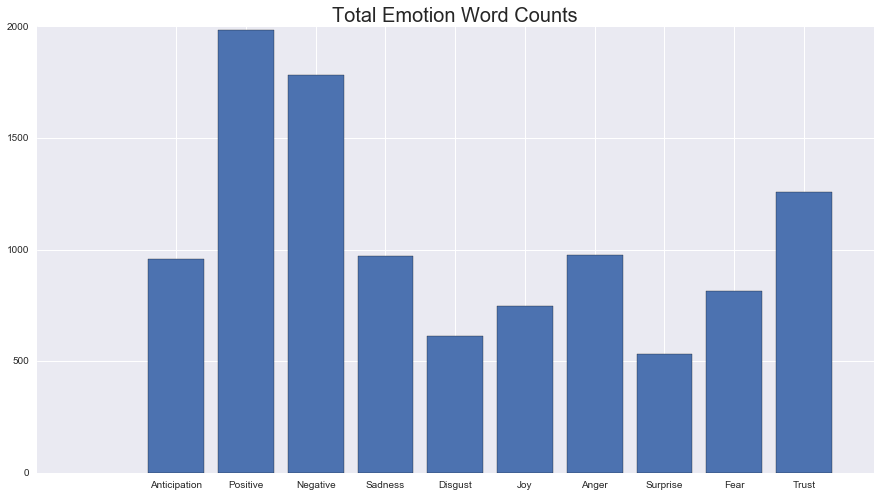

In [33]:
emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(dt[key])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

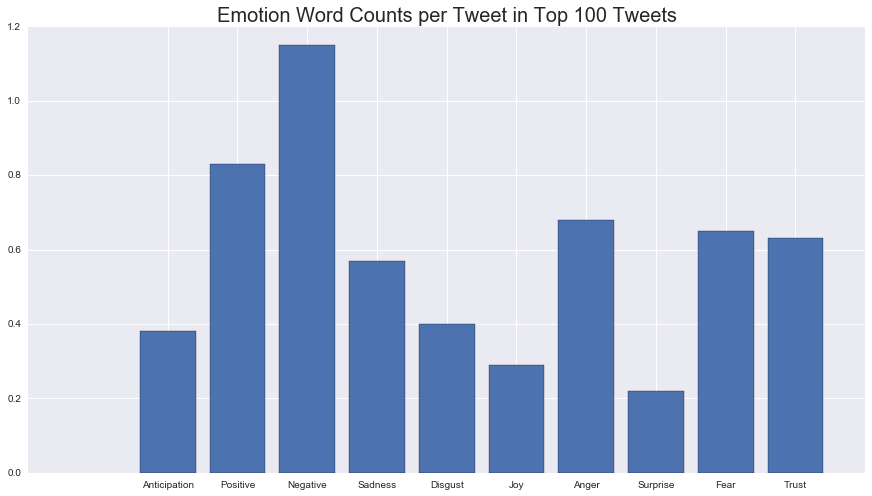

In [34]:
by_favorite = dt.sort(['favorite_count'], ascending = False)

emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(by_favorite[key][:100]) / 100.0

plt.figure(figsize=(15,8))
plt.title('Emotion Word Counts per Tweet in Top 100 Tweets', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

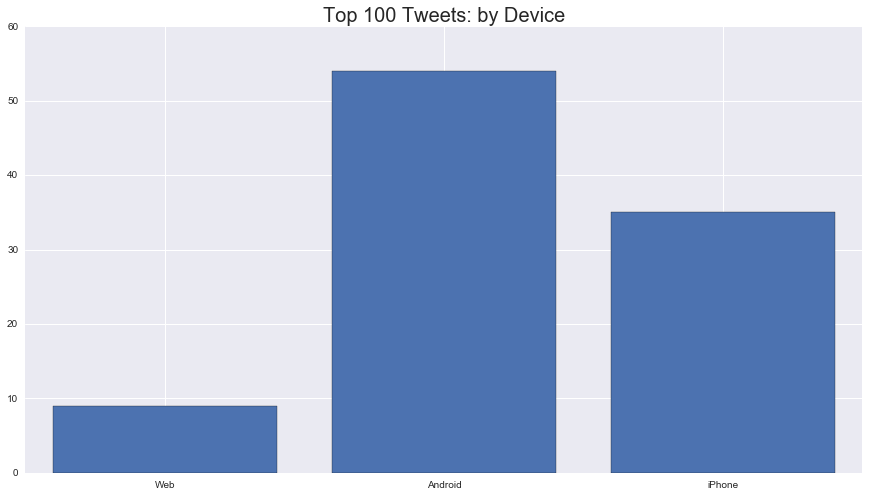

In [58]:
# To do: why does chart now say 90 tweets? also, relate total number of tweets per phone: how many total tweets for each phone

phones = ['Android', 'iPhone', 'Web']
top_100_by_phone = dict()
for key in phones:
    top_100_by_phone[key] = len(by_favorite['source'][:100][by_favorite['source'] == key])
    
plt.figure(figsize=(15,8))
plt.title('Top 100 Tweets: by Device', fontsize = 20)
plt.bar(range(len(top_100_by_phone)), top_100_by_phone.values(), align='center', )
plt.xticks(range(len(top_100_by_phone)), top_100_by_phone.keys())

plt.show()

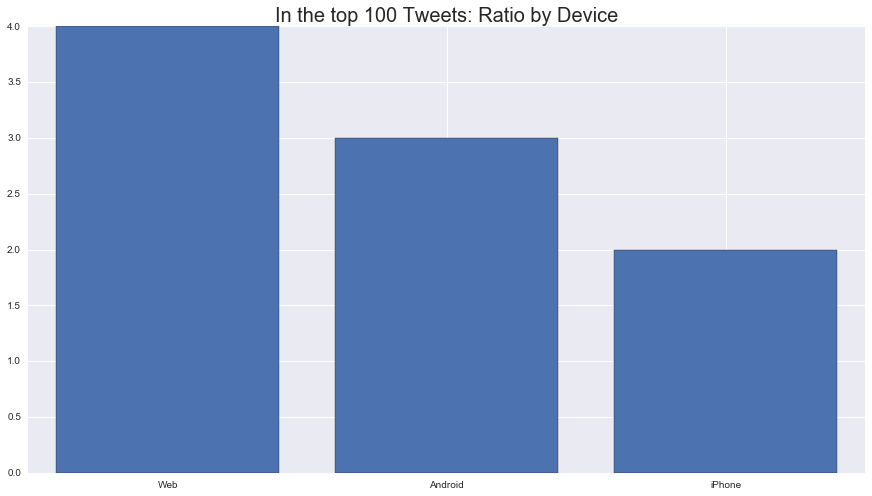

In [60]:
phones = ['Android', 'iPhone', 'Web']
top_100_by_phone = dict()
for key in phones:
    top_100_by_phone[key] = len(by_favorite['source'][:100][by_favorite['source'] == key]) / (sum(dt['source']==key)/100)
    
plt.figure(figsize=(15,8))
plt.title('In the top 100 Tweets: Ratio by Device', fontsize = 20)
plt.bar(range(len(top_100_by_phone)), top_100_by_phone.values(), align='center', )
plt.xticks(range(len(top_100_by_phone)), top_100_by_phone.keys())

plt.show()

The x-axis numbers are a little strange, but this chart looks at number of tweets in the top 100 against how many tweets were made from that device. It looks like desktop had the best ratio, then Android, then iPhone.

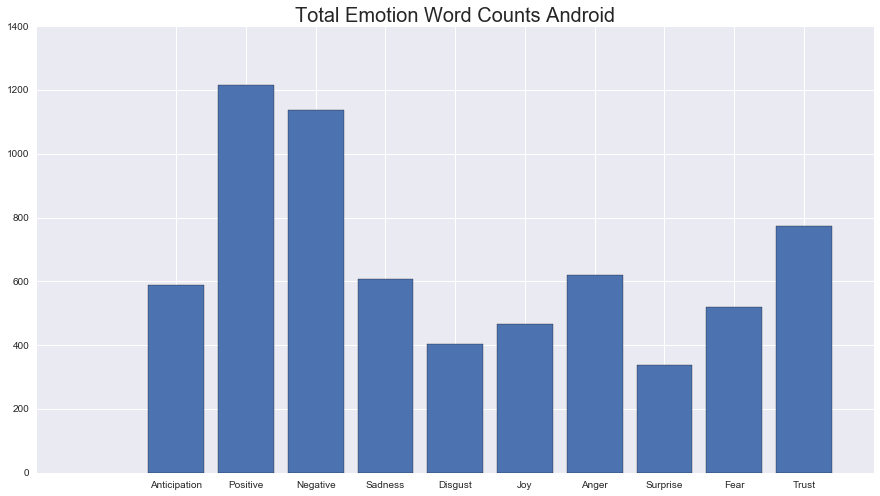

In [61]:
emotion_sums_android = dict()
for key in affects:
    emotion_sums_android[key] = sum(dt[key][dt['source']=='Android'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts Android', fontsize = 20)
plt.bar(range(len(emotion_sums_android)), emotion_sums_android.values(), align='center', )
plt.xticks(range(len(emotion_sums_android)), emotion_sums_android.keys())

plt.show()

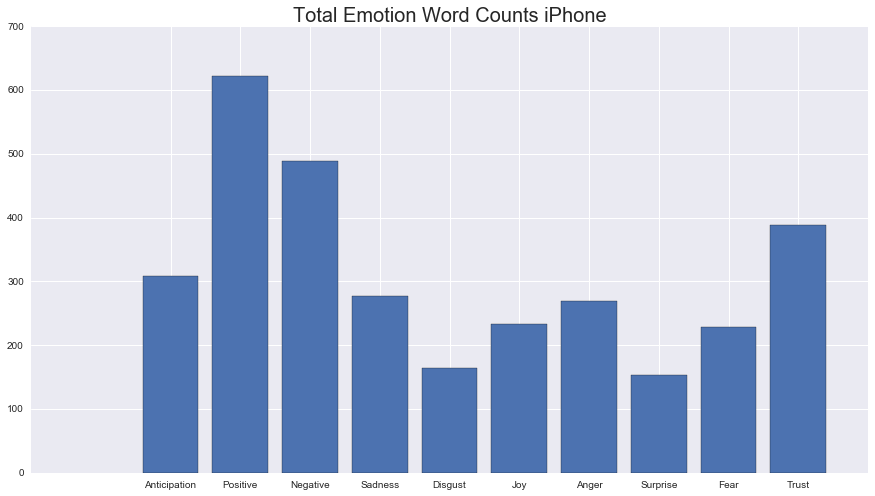

In [62]:
emotion_sums_iphone = dict()
for key in affects:
    emotion_sums_iphone[key] = sum(dt[key][dt['source']=='iPhone'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts iPhone', fontsize = 20)
plt.bar(range(len(emotion_sums_iphone)), emotion_sums_iphone.values(), align='center', )
plt.xticks(range(len(emotion_sums_iphone)), emotion_sums_iphone.keys())

plt.show()

Fairly similar distributions, though it looks like iPhone tweets contained far fewer negative words.

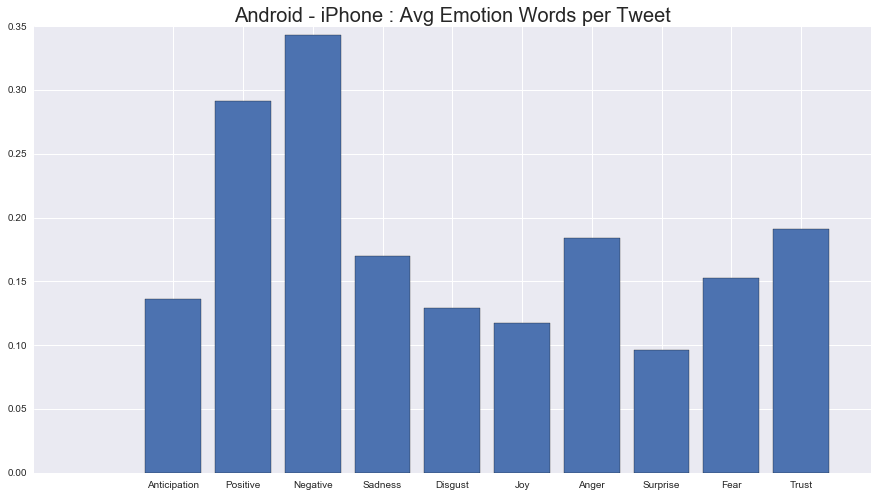

In [35]:
# almost same number of iPhone/Android tweets, Android tweets contain more emotion words on average in all categories

emotion_avg_iphone = {key: (emotion_sums_iphone[key] / float(len(dt[dt['source']=='iPhone'])))  for key in emotion_sums_iphone.keys()}
emotion_avg_android = {key: (emotion_sums_android[key] / float(len(dt[dt['source']=='Android'])))  for key in emotion_sums_android.keys()}

emotions_diff = {key: emotion_avg_android[key] - emotion_avg_iphone.get(key, 0) for key in emotion_avg_android.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Avg Emotion Words per Tweet', fontsize = 20)
plt.bar(range(len(emotions_diff)), emotions_diff.values(), align='center', )
plt.xticks(range(len(emotions_diff)), emotions_diff.keys())

plt.show()

Android tweets contain more emotion words in every single category: an Android tweet is much more likely to contain emotional words than an iPhone tweet.

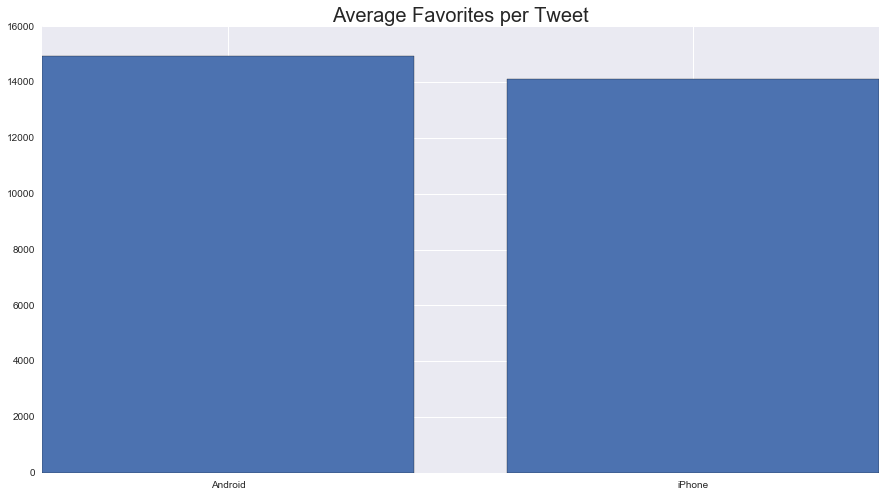

In [65]:
phones = ['Android', 'iPhone']
favorite_by_phone = dict()
for key in phones:
    favorite_by_phone[key] = sum(dt['favorite_count'][dt['source'] == key]) / len(dt[dt['source'] == key])

plt.figure(figsize=(15,8))
plt.title('Average Favorites per Tweet', fontsize = 20)
plt.bar(range(len(favorite_by_phone)), favorite_by_phone.values(), align='center', )
plt.xticks(range(len(favorite_by_phone)), favorite_by_phone.keys())

plt.show()

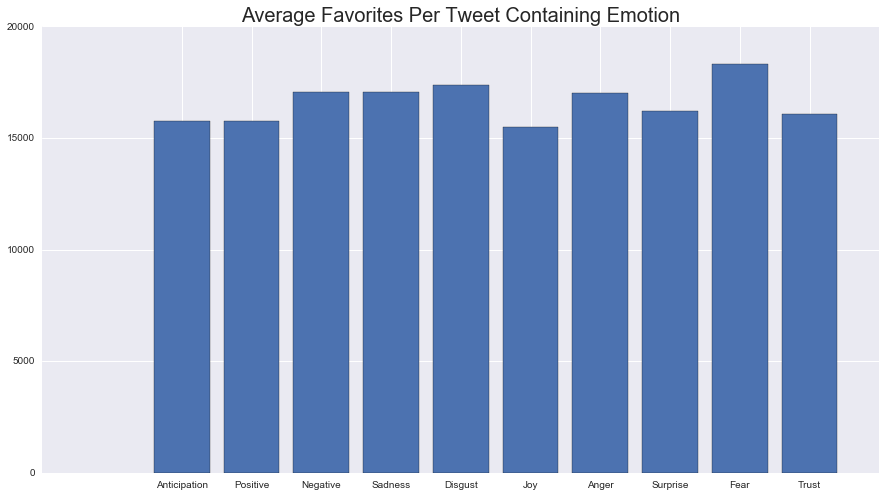

In [66]:
favorite_emotions = dict()
for key in affects:
    favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0]) / len(dt[dt[key] > 0])

plt.figure(figsize=(15,8))
plt.title('Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(favorite_emotions)), favorite_emotions.values(), align='center', )
plt.xticks(range(len(favorite_emotions)), favorite_emotions.keys())

plt.show()

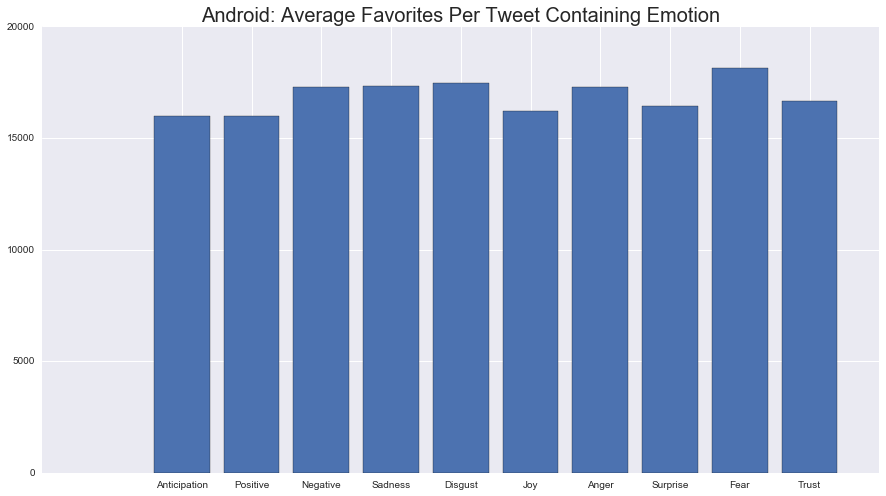

In [70]:
android_favorite_emotions = dict()
for key in affects:
    android_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'Android']) / len(dt[dt[key] > 0][dt['source'] == 'Android'])

plt.figure(figsize=(15,8))
plt.title('Android: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(android_favorite_emotions)), android_favorite_emotions.values(), align='center', )
plt.xticks(range(len(android_favorite_emotions)), android_favorite_emotions.keys())

plt.show()

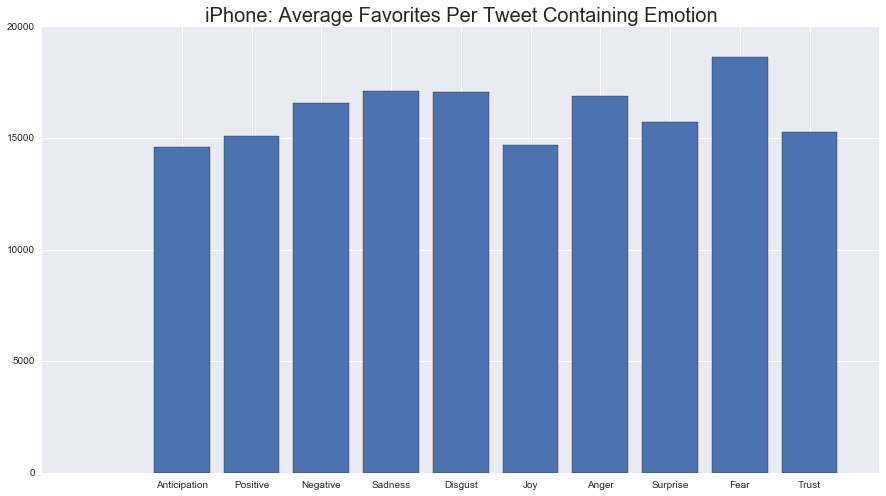

In [68]:
iphone_favorite_emotions = dict()
for key in affects:
    iphone_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'iPhone']) / len(dt[dt[key] > 0][dt['source'] == 'iPhone'])

plt.figure(figsize=(15,8))
plt.title('iPhone: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.values(), align='center', )
plt.xticks(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.keys())

plt.show()

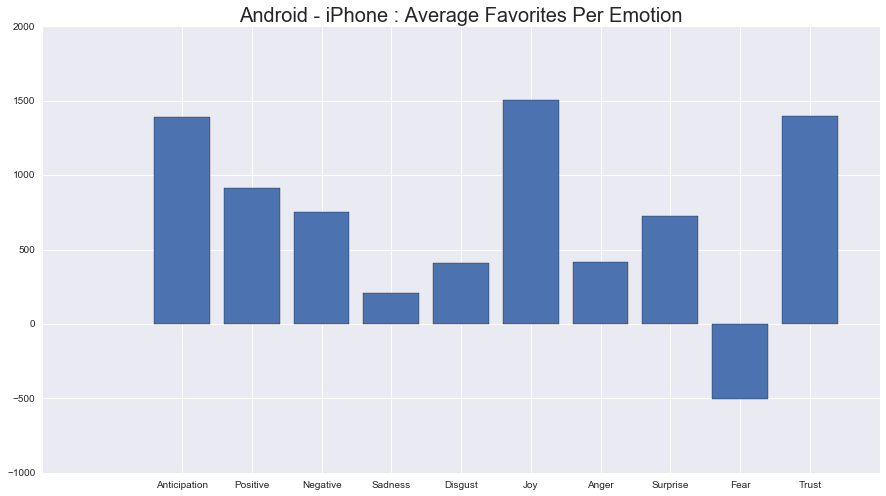

In [69]:
fav_emotions_diff = {key: android_favorite_emotions[key] - iphone_favorite_emotions.get(key, 0) for key in android_favorite_emotions.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Average Favorites Per Emotion', fontsize = 20)
plt.bar(range(len(fav_emotions_diff)), fav_emotions_diff.values(), align='center', )
plt.xticks(range(len(fav_emotions_diff)), fav_emotions_diff.keys())

plt.show()

This isn't too surprising given that Android tweets get more favorites on average by a significant margin.

In [ ]:
# the same graph, choose a custom range of tweets to monitor how emotion content changes over time
# 0 is the most recent tweet (August 2016), 3199 is the oldest (December 2015)

# most recent 500
mystart = 0
mystop = 500

def plot_range(mystart, mystop):
    android_favorite_emotions_X = dict()
    for key in affects:
        android_favorite_emotions_X[key] = sum(dt[mystart:mystop]['favorite_count'][dt[key] > 0][dt['source'] == 'Android']) / len(dt[mystart:mystop][dt[key] > 0][dt['source'] == 'Android'])

    iphone_favorite_emotions_X = dict()
    for key in affects:
        iphone_favorite_emotions_X[key] = sum(dt[mystart:mystop]['favorite_count'][dt[key] > 0][dt['source'] == 'iPhone']) / len(dt[mystart:mystop][dt[key] > 0][dt['source'] == 'iPhone'])

    avg_fav_iPhone_X = sum(dt[mystart:mystop]['favorite_count'][dt['source'] == 'iPhone']) / len(dt[mystart:mystop][dt['source'] == 'iPhone'])
    avg_fav_Android_X = sum(dt[mystart:mystop]['favorite_count'][dt['source'] == 'Android']) / len(dt[mystart:mystop][dt['source'] == 'Android'])    

    fav_emotions_diff_X = {key: android_favorite_emotions_X[key] - iphone_favorite_emotions_X.get(key, 0) for key in android_favorite_emotions_X.keys()}

    plt.figure(figsize=(15,8))
    plt.title('Android - iPhone : Average Favorites Per Emotion', fontsize = 20)
    plt.bar(range(len(fav_emotions_diff_X)), fav_emotions_diff_X.values(), align='center', )
    plt.xticks(range(len(fav_emotions_diff_X)), fav_emotions_diff_X.keys())

    plt.show()
    
plot_range(mystart, mystop)

Let's subtract the mean number of favorites for each phone from each phone dictionary: this will give us a better picture of the differences between the two phones than our previous graph, which skews all emotions towards Android because each Android tweet gets more favorites on average.

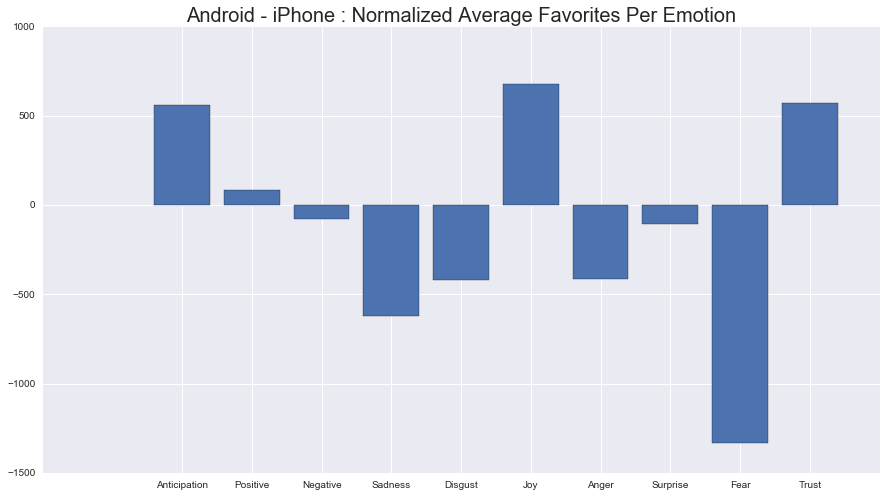

In [94]:
# for android and iphone, subtract the mean favorites for each phone before comparing between phones
avg_fav_iPhone = sum(dt['favorite_count'][dt['source'] == 'iPhone']) / len(dt[dt['source'] == 'iPhone'])
avg_fav_Android = sum(dt['favorite_count'][dt['source'] == 'Android']) / len(dt[dt['source'] == 'Android'])

fav_emotions_diff = {key: (android_favorite_emotions[key] - avg_fav_Android) - (iphone_favorite_emotions.get(key, 0) - avg_fav_iPhone) for key in android_favorite_emotions.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Normalized Average Favorites Per Emotion', fontsize = 20)
plt.bar(range(len(fav_emotions_diff)), fav_emotions_diff.values(), align='center', )
plt.xticks(range(len(fav_emotions_diff)), fav_emotions_diff.keys())

plt.show()

In [ ]:
# normalized graph 

mystart = 0
mystop = 500

def plot_range_normalized(mystart, mystop):
    android_favorite_emotions_X = dict()
    for key in affects:
        android_favorite_emotions_X[key] = sum(dt[mystart:mystop]['favorite_count'][dt[key] > 0][dt['source'] == 'Android']) / len(dt[mystart:mystop][dt[key] > 0][dt['source'] == 'Android'])

    iphone_favorite_emotions_X = dict()
    for key in affects:
        iphone_favorite_emotions_X[key] = sum(dt[mystart:mystop]['favorite_count'][dt[key] > 0][dt['source'] == 'iPhone']) / len(dt[mystart:mystop][dt[key] > 0][dt['source'] == 'iPhone'])

    avg_fav_iPhone_X = sum(dt[mystart:mystop]['favorite_count'][dt['source'] == 'iPhone']) / len(dt[mystart:mystop][dt['source'] == 'iPhone'])
    avg_fav_Android_X = sum(dt[mystart:mystop]['favorite_count'][dt['source'] == 'Android']) / len(dt[mystart:mystop][dt['source'] == 'Android'])    

    fav_emotions_diff_X = {key: (android_favorite_emotions_X[key] - avg_fav_Android_X) - (iphone_favorite_emotions_X.get(key, 0) - avg_fav_iPhone_X) for key in android_favorite_emotions_X.keys()}

    plt.figure(figsize=(15,8))
    plt.title('Android - iPhone : Normalized Average Favorites Per Emotion', fontsize = 20)
    plt.bar(range(len(fav_emotions_diff_X)), fav_emotions_diff_X.values(), align='center', )
    plt.xticks(range(len(fav_emotions_diff_X)), fav_emotions_diff_X.keys())

    plt.show()
    
plot_range_normalized(mystart, mystop)

Insights:
- Android tweets are more emotional
- Among the top favorited tweets, negativity and fear dominate
- Tweets with fear and disgust get more favorites overall
- More top tweets come from Android
- Overall, Android and iPhone have similar distribution of emotions
- Surprisingly, tweets from Android conveying anticipation, joy, and trust garner more favorites than those on iPhone. This is exactly the opposite conclusion I reached when working on a smaller, more recent dataset, where my results were as follows:

<img src = "trump_tweet_difference.png">

"Despite having similar proportions of emtions, Android tweets conveying negativity, disgust, anger, and surprise garner  significantly more favorites, and iPhone tweets conveying anticipation, positivity, sadness, joy, and trust garner significantly more favorites. Android is better at garnering favorites from negative sentiments, iPhone is better at garnering favorites from positive sentiments; each one is attracting a different kind of audience." Which seems to match the analysis of previous graphs.

I had to check the math by hand on a few of these just to make sure they're correct. Without really rolling up my sleeves I can't determine why my first dataset produced such radically different results than my second.

In [117]:
def get_word_counts(df):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = 'english', 
                                       max_features = 1000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df['text'])
    grams = count_vect.get_feature_names()
    dist = np.sum(matrix.toarray(), axis = 0)
    grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[:10]

In [118]:
import sys

In [119]:
get_word_counts(dt)

In [120]:
def clusters(df, clusters_count = 5):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = 'english', 
                                       max_features = 20000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df['text'])
    grams = count_vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(clusters_count):
        print "\nCluster %d:" % i
        print ', '.join([grams[ind] for ind in order_centroids[i, :50]]) 
    return km

In [121]:
clusters(dt)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [122]:
#tfid clusters
from sklearn.feature_extraction import text 

def clusters_tfidf(df, clusters_count = 5):
    vect = TfidfVectorizer(max_df = 0.5, max_features = 200000,
                                 min_df = 5, stop_words = text.ENGLISH_STOP_WORDS.union(['https']),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(df['text']) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(clusters_count):
        print "\nCluster %d:" % i
        print ', '.join([terms[ind] for ind in order_centroids[i, :50]]) 
    return km

In [123]:
clusters_tfidf(dt)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Output to terminal...Here's what it produced:

Cluster 0:
trump2016, thank, makeamericagreatagain, new, america, votetrump, poll, indiana, supertuesday, hampshire, americafirst, california, great, pennsylvania, soon, arizona, fitn, florida, support, york, tomorrow, carolina, iowa, video, south, virginia, amp, louisiana, join, imwithyou, michigan, connecticut, maryland, iacaucus, wiprimary, nevada, love, texas, illinois, ohio, nebraska, georgia, just, north, ivankatrump, nyprimary, trumptrain, missouri, trump, maine

Cluster 1:
hillary, clinton, crooked, bad, bernie, isis, said, beat, just, judgement, obama, women, president, sanders, amp, people, totally, want, believe, wall, rigged, wants, don, person, husband, change, street, video, run, country, years, media, really, jobs, trump, says, campaign, cnn, time, speech, look, doesn, corrupt, foreign, ads, ad, like, emails, money, judgment

Cluster 2:
realdonaldtrump, trump, great, megynkelly, thank, rt, makeamericagreatagain, president, thanks, love, cnn, america, vote, foxnews, mr, amp, jebbush, donald, tedcruz, best, interview, like, good, people, need, gop, danscavino, job, cruz, rally, loves, want, won, trumptrain, time, media, hillaryclinton, make, hillary, trump2016, just, tonight, debate, voted, voting, country, iowa, knows, win, neilturner_

Cluster 3:
america, make, great, safe, thank, trump, going, vote, big, votetrump, trump2016, amp, new, day, south, country, carolina, inprimary, support, crowd, americafirst, today, tuesday, nevada, realdonaldtrump, trumppence16, year, wisconsin, lets, finally, michigan, future, tonight, just, time, amazing, movement, caucusfortrump, votetrumpsc, mr, lead, donald, let, york, win, 2016, night, monday, state, virginia

Cluster 4:
trump, great, thank, people, amp, cruz, just, new, ted, enjoy, big, tonight, trump2016, foxnews, join, today, interviewed, rubio, like, president, cnn, rt, vote, amazing, republican, tomorrow, night, time, media, iowa, 000, win, campaign, going, job, poll, morning, good, speech, wow, donald, watch, country, won, don, way, jeb, said, crowd, support


In [124]:
def print_top_words(model, feature_names, n_top_words = 20):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print "\nTopic #%d:" % topic_idx
        print ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [125]:
def get_topics_lda_tfidf(docs, df, n_topics = 5):   
    vect = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 5, stop_words = text.ENGLISH_STOP_WORDS.union(['https']),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    #print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [126]:
lda_tfidf, topics_tfidf, prepared_tfidf = get_topics_lda_tfidf(dt['text'], dt, 5)

In [127]:
prepared_tfidf

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      47.535611        1       1  0.153633  0.057378
1      19.033063        1       2  0.106519  0.016419
3      14.411828        1       3 -0.178915  0.059742
4      11.358649        1       4 -0.015779 -0.173446
2       7.660849        1       5 -0.065458  0.039908, topic_info=     Category         Freq                   Term        Total  loglift  \
term                                                                      
989   Default  5435.000000                  thank  5435.000000  30.0000   
1025  Default  4835.000000              trump2016  4835.000000  29.0000   
608   Default  3953.000000  makeamericagreatagain  3953.000000  28.0000   
58    Default  2855.000000                america  2855.000000  27.0000   
607   Default  2139.000000                   make  2139.000000  26.0000   
411   Default  4065.000000                  great  406

In [54]:
pyLDAvis.display(prepared_tfidf)